# ====================================================================
# QUANTUM COMPUTING QUBIT PATENT CLASSIFICATION WITH DEEP LEARNING
# ====================================================================

Patent offices around the world issue millions of patents every year.  It is difficult for companies with large patent portfolios to understand and manage their patent assets for a specific technology area.  Machine learning can help automate tasks that have previously been entirely handled by human beings.  This problem is an attempt to demonstrate the ability of machine learning to classify patents as belonging in a particular category of asset, in this case whether a patent is related to Quantum Computing Qubit technology or not.  For this particular exercise, we are relying exclusively on patent metadata information (title, publication date, serial number, family id).  While more accurate results would be achievable using the full text and drawings of a full patent document, that would require significantly more processing power.  As shown below in the results section, the accuracy, precision, recall, and F1 scores are reasonably good even without using the full text.  

I analyze the patent test titles and other metadata information using recurrent neural network techniques, comparing LSTM, bidirectional LSTM, and GRU.  Binary classification of quantum computing patents is perfomred to determine whether the patents refer to qubit generation hardware or not. This is an NLP task requiring understanding of quantum computing terminology, patent language, and distinguishing between hardware and software/algorithmic aspects of quantum computing.  

This sort of machine learning task is easily translatable to other technologies beyond Qubits to enable companies to analyze their IP portfolios for specific areas of investment.

There are two versions of this program: One program that cleanses the dataset of additional patent family members and this version that contains the full dataset.  The full dataset version has higher accuracy, recall, precision, and F1 scores because classifying additional family members is a very easy problem (i.e. accuracy should be near 100%), and over 70% of the full dataset are addtiional patent family members.

Qubit Generation for Quantum Computing Dataset Structure:
- Column 1: Classification (negative/positive for qubit related) (col. 1 generated by human beings as described in Harris article below)
- Column 2: DocDB Family ID
- Column 3: Serial No.
- Column 4: Title of patent application (main text for classification)
- Column 5: Publication date

Description of the Binary Classification: 
"Qubit Generation for Quantum Computing refers to patents that discuss the various means of generating qubits for use in a quantum mechanics based
computing system. Types of qubits included superconducting loops, topological, quantum dot based and ion-trap methods as well as others. The excluded
technologies are applications, algorithms and other auxiliary aspects of quantum computing that do not mention a hardware component, and hardware for
other quantum phenomena outside of qubit generation."

References

Dataset located at: 
https://github.com/swh/classification-gold-standard

See this article for the background behind the creation of the dataset.  Steve Harris, Anthony Trippe, David Challis, and Nigel Swycher, "Construction and evaluation of gold standards for patent classification—A case study on quantum computing", World Patent Information, 2020.  
https://www.sciencedirect.com/science/article/pii/S0172219019300791


This Jupyter Notebook python code was written using Anaconda Navigator and is located at: https://github.com/tomplunkett/Data-Science/tree/main/Deep%20Learning%20Patents


In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout, Embedding, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)



In [3]:
# ====================================================================
# 1. DATA LOADING
# ====================================================================

def load_patent_data(file_path):
    """
    Load patent data with structure:
    Column 1: Classification (negative/positive for qubit related)
    Column 2: DocDB Family ID
    Column 3: Serial No.
    Column 4: Title of patent application
    Column 5: Publication date
    """
    print(f"Loading patent data from: {file_path}")
    
    df = pd.read_csv(file_path, sep='\t', engine='python', quoting=3, encoding='utf-8')
    print(f"Successfully loaded data")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    return df

In [4]:
# 2. Load the data
file_path = "data/patent_deep_learning/quantum-qubit-generation.tsv"
df = load_patent_data(file_path)


# Ensure we have the expected columns
expected_columns = ['classification', 'docdb_family_id', 'serial_no', 'title', 'publication_date']
if len(df.columns) >= 5:
    df.columns = expected_columns[:len(df.columns)]
elif len(df.columns) >= 4:
    # If no publication date column
    df.columns = expected_columns[:4]
    df['publication_date'] = 'Unknown'
else:
    # Auto-detect and rename
    df.columns = expected_columns[:len(df.columns)]

print(f"Dataset Shape: {df.shape}")
print(f"Dataset Columns: {list(df.columns)}")
print(f"Missing Values:\n{df.isnull().sum()}")

# Convert classification to binary
df['target'] = df['classification'].map({'positive': 1, 'negative': 0})
if df['target'].isnull().any():
    # Handle other possible values
    unique_classifications = df['classification'].unique()
    print(f"Unique classifications found: {unique_classifications}")
    # Map first unique value to 0, second to 1
    if len(unique_classifications) >= 2:
        mapping = {unique_classifications[0]: 0, unique_classifications[1]: 1}
        df['target'] = df['classification'].map(mapping)
        print(f"Applied mapping: {mapping}")

# Drop the original classification column since target contains the binary mapping
df = df.drop('classification', axis=1)
print(f"Dropped 'classification' column. Remaining columns: {list(df.columns)}")

#This next section commmented out from this program to keep the full data set
# Remove duplicate DocDB Family IDs to prevent data leakage (i.e. I don't want members of same family in both test and training)
# This will also increase performance significantly, dropping the data set size to about 1/3 of the current size
#print(f"\nRemoving duplicate DocDB Family IDs...")
#print(f"Original dataset size: {len(df)}")
#print(f"Unique DocDB Family IDs: {df['docdb_family_id'].nunique()}")
#print(f"Duplicate DocDB Family IDs: {len(df) - df['docdb_family_id'].nunique()}")

# Keep only the first occurrence of each DocDB Family ID
#df_deduplicated = df.drop_duplicates(subset=['docdb_family_id'], keep='first')
#print(f"Dataset size after deduplication: {len(df_deduplicated)}")
#print(f"Removed {len(df) - len(df_deduplicated)} duplicate entries")

# Update df to the deduplicated version
#df = df_deduplicated

# Display first few rows
print(f"\nFirst 3 rows:")
for i in range(min(3, len(df))):
    print(f"Row {i+1}:")
    print(f"  DocDB Family ID: {df['docdb_family_id'].iloc[i]}")
    print(f"  Serial No.: {df['serial_no'].iloc[i]}")
    print(f"  Title: {str(df['title'].iloc[i])[:200]}...")
    print(f"  Publication Date: {df['publication_date'].iloc[i]}")
    print(f"  Target: {df['target'].iloc[i]}")

# Basic statistics
print(f"\nTarget Distribution:")
target_counts = df['target'].value_counts()
print(target_counts)
positive_ratio = target_counts.get(1, 0) / len(df) * 100
print(f"Class Balance: {positive_ratio:.1f}% positive class (qubit-related)")

# Text length analysis on titles
df['title_length'] = df['title'].astype(str).str.len()
df['word_count'] = df['title'].astype(str).str.split().str.len()

print(f"\nTitle Statistics:")
print(f"Average title length: {df['title_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Max title length: {df['title_length'].max()} characters")
print(f"Min title length: {df['title_length'].min()} characters")

# Remove any rows with missing title or target
df = df.dropna(subset=['title', 'target'])
print(f"Dataset shape after removing missing values: {df.shape}")

# Split data into train and test (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

print(f"\nData Split:")
print(f"Training set: {train_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")
print(f"Training target distribution: {train_df['target'].value_counts().to_dict()}")
print(f"Test target distribution: {test_df['target'].value_counts().to_dict()}")

Loading patent data from: data/patent_deep_learning/quantum-qubit-generation.tsv
Successfully loaded data
Shape: (5083, 5)
Columns: ['Class', 'DocDB Family ID', 'Serial no.', 'Title', 'Publication date']
Dataset Shape: (5083, 5)
Dataset Columns: ['classification', 'docdb_family_id', 'serial_no', 'title', 'publication_date']
Missing Values:
classification      0
docdb_family_id     0
serial_no           0
title               4
publication_date    0
dtype: int64
Dropped 'classification' column. Remaining columns: ['docdb_family_id', 'serial_no', 'title', 'publication_date', 'target']

First 3 rows:
Row 1:
  DocDB Family ID: 10750653
  Serial No.: AT196013T
  Title: NACHWEISUNG VON ELEKTROMAGNETISCHEN FELDERN...
  Publication Date: 2000-09-15
  Target: 0
Row 2:
  DocDB Family ID: 10750653
  Serial No.: AU1703095A
  Title: Detection of electromagnetic fields...
  Publication Date: 1995-09-11
  Target: 0
Row 3:
  DocDB Family ID: 10750653
  Serial No.: CA2183742A1
  Title: DETECTION OF ELEC



EXPLORATORY DATA ANALYSIS
--------------------------------------------------


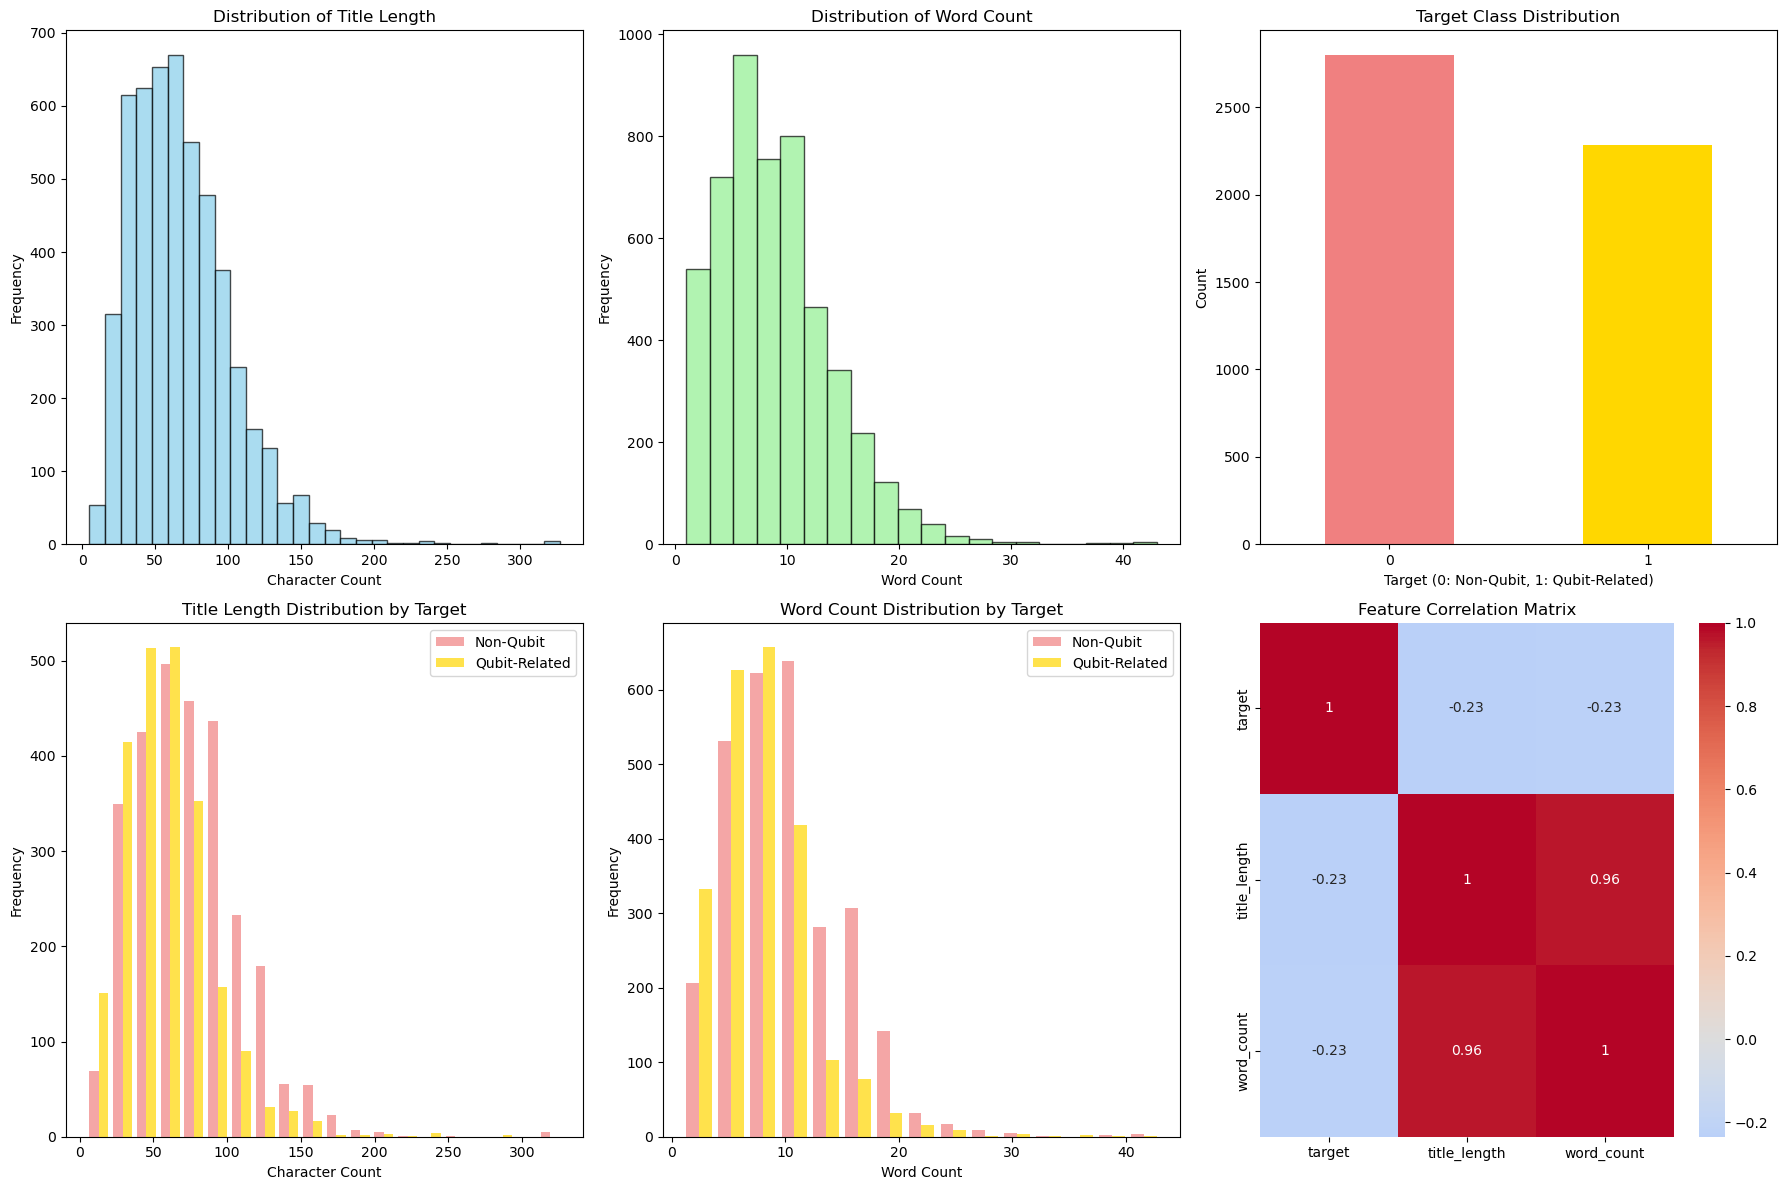


Sample Patent Titles:

Non-Qubit Related patent examples:
1. NACHWEISUNG VON ELEKTROMAGNETISCHEN FELDERN
2. Detection of electromagnetic fields
3. DETECTION OF ELECTROMAGNETIC FIELDS
4. DETECTION OF ELECTROMAGNETIC FIELDS
5. According to signals of electromagnetic fields

Qubit-Related patent examples:
1. The surface canning where resistance blade tipping Characteristic is superior manufacturing method null of the cemented carbide make cutting
2. Production method of surface-coated cemented carbide cutting tools with excellent chipping resistance
3. Quantum operation component and its use manner
4. Quantum operation component
5. Quantum operational device


In [5]:
# ====================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ====================================================================

print("\n\nEXPLORATORY DATA ANALYSIS")
print("-" * 50)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Title length distribution
axes[0,0].hist(df['title_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Title Length')
axes[0,0].set_xlabel('Character Count')
axes[0,0].set_ylabel('Frequency')

# Word count distribution
axes[0,1].hist(df['word_count'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Word Count')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')

# Target distribution
target_counts.plot(kind='bar', ax=axes[0,2], color=['lightcoral', 'gold'])
axes[0,2].set_title('Target Class Distribution')
axes[0,2].set_xlabel('Target (0: Non-Qubit, 1: Qubit-Related)')
axes[0,2].set_ylabel('Count')
axes[0,2].tick_params(axis='x', rotation=0)

# Title length by target
positive_lengths = df[df['target']==1]['title_length']
negative_lengths = df[df['target']==0]['title_length']

axes[1,0].hist([negative_lengths, positive_lengths], bins=20, alpha=0.7, 
               label=['Non-Qubit', 'Qubit-Related'], color=['lightcoral', 'gold'])
axes[1,0].set_title('Title Length Distribution by Target')
axes[1,0].set_xlabel('Character Count')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Word count by target
positive_words = df[df['target']==1]['word_count']
negative_words = df[df['target']==0]['word_count']

axes[1,1].hist([negative_words, positive_words], bins=15, alpha=0.7,
               label=['Non-Qubit', 'Qubit-Related'], color=['lightcoral', 'gold'])
axes[1,1].set_title('Word Count Distribution by Target')
axes[1,1].set_xlabel('Word Count')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

# Correlation heatmap
correlation_data = df[['target', 'title_length', 'word_count']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Sample patent titles
print("\nSample Patent Titles:")
print("\nNon-Qubit Related patent examples:")
non_qubit_samples = df[df['target']==0]['title'].head(5)
for i, title in enumerate(non_qubit_samples):
    print(f"{i+1}. {str(title)}")

print("\nQubit-Related patent examples:")
qubit_samples = df[df['target']==1]['title'].head(5)
for i, title in enumerate(qubit_samples):
    print(f"{i+1}. {str(title)}")

In [6]:
# ====================================================================
# 4. DATA PREPROCESSING AND CLEANING
# ====================================================================

print("\n\nDATA PREPROCESSING AND CLEANING")
print("-" * 50)

def preprocess_patent_title(text):
    """
    Comprehensive text preprocessing for patent titles
    """
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove patent-specific patterns
    text = re.sub(r'us\s*\d+', '', text)  # Remove US patent numbers
    text = re.sub(r'patent\s*(application|no\.?)', '', text)  # Remove patent references
    
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Keep alphanumeric characters and basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\;\:\!\?\-]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
train_df = train_df.copy()
test_df = test_df.copy()
train_df['title_clean'] = train_df['title'].apply(preprocess_patent_title)
test_df['title_clean'] = test_df['title'].apply(preprocess_patent_title)

# Remove empty titles
train_df = train_df[train_df['title_clean'].str.len() > 0]
test_df = test_df[test_df['title_clean'].str.len() > 0]

print(f"Training data shape after cleaning: {train_df.shape}")
print(f"Test data shape after cleaning: {test_df.shape}")
print("\nPreprocessing example:")
if len(train_df) > 0:
    print(f"Original: {str(train_df['title'].iloc[0])}")
    print(f"Cleaned:  {train_df['title_clean'].iloc[0]}")



DATA PREPROCESSING AND CLEANING
--------------------------------------------------
Training data shape after cleaning: (4063, 8)
Test data shape after cleaning: (1016, 8)

Preprocessing example:
Original: OPTICALLY DITHERED ATOMIC GYRO-COMPASS
Cleaned:  optically dithered atomic gyro-compass



# Keras Embedding Layer for Patent Titles

Use Keras' trainable embedding layer optimized for patent title text:
A. Create domain-specific vocabulary from patent title corpus.
B. Map technical terms to unique integer IDs.
C. Learn dense vector representations during training.
D. Adapt embeddings specifically for quantum computing patent classification.

PATENT TITLE CONSIDERATIONS:  Patent title text typically has a focused vocabulary for concise title text.  The titles include technical terms and compound words, however have shorter text sequences compared to full patent documents.  The syntax of patent titles follows a formal approach.    

PARAMETERS:
    Vocabulary size: Based on actual title vocabulary
    Embedding dimension: 64 (appropriate for title-length text)
    Maximum sequence length of Patent Titlte: Based on title word count distribution (typically 18 or so words)


In [8]:
#5. Tokenization parameters - adjusted for patent titles
title_vocab = ' '.join(train_df['title_clean']).split()
MAX_FEATURES = min(10000, len(set(title_vocab)))  # Adjust based on actual vocabulary
MAX_LEN = min(50, int(train_df['title_clean'].str.split().str.len().quantile(0.95)))  # Use 95th percentile
EMBEDDING_DIM = 64   # Appropriate for shorter title text

print(f"Title vocabulary size: {len(set(title_vocab))}")
print(f"MAX_FEATURES: {MAX_FEATURES}")
print(f"MAX_LEN: {MAX_LEN}")

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['title_clean'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['title_clean'])
X_test_seq = tokenizer.texts_to_sequences(test_df['title_clean'])

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare target variables
y_train = train_df['target'].values
y_test = test_df['target'].values

# Train-validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training sequences shape: {X_train_final.shape}")
print(f"Validation sequences shape: {X_val.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")

Title vocabulary size: 2866
MAX_FEATURES: 2866
MAX_LEN: 18
Training sequences shape: (3250, 18)
Validation sequences shape: (813, 18)
Test sequences shape: (1016, 18)
Vocabulary size: 2556


In [9]:
# ====================================================================
# 6. MODEL ARCHITECTURE
# ====================================================================



def create_lstm_model():
    """Enhanced LSTM model for patent title classification"""
    vocab_size = len(tokenizer.word_index) + 1
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_bidirectional_lstm_model():
    """Enhanced Bidirectional LSTM model for patent title classification"""
    vocab_size = len(tokenizer.word_index) + 1
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_gru_model():
    """Enhanced GRU model for patent title classification"""
    vocab_size = len(tokenizer.word_index) + 1
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        GRU(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
# ====================================================================
# 7. MODEL TRAINING
# ====================================================================


# Training parameters optimized for patent title classification
BATCH_SIZE = 32       # Standard batch size
EPOCHS = 15           # Reduced for demonstration
LEARNING_RATE = 0.001  # Standard learning rate

# Dictionary to store models and results
models = {
    'LSTM': create_lstm_model(),
    'Bidirectional_LSTM': create_bidirectional_lstm_model(),
    'GRU': create_gru_model()
}

results = {}

for i, (name, model) in enumerate(models.items()):
    print(f"\nTraining {name} model...")
    
    # Use different random seeds for each model
    tf.random.set_seed(42 + i)
    np.random.seed(42 + i)
    
    # Model-specific callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
    
    callbacks = [early_stopping, reduce_lr]
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Build model explicitly to count parameters
    model.build(input_shape=(None, MAX_LEN))
    
    # Display model architecture
    print(f"\n{name} Model Architecture:")
    print(f"Total params: {model.count_params():,}")
    
    # Train model
    history = model.fit(
        X_train_final, y_train_final,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Calculate metrics
    final_val_acc = history.history['val_accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    
    # Store results
    results[name] = {
        'model': model,
        'history': history,
        'val_accuracy': best_val_acc,
        'val_loss': best_val_loss,
        'final_val_accuracy': final_val_acc,
        'final_val_loss': final_val_loss,
        'epochs_trained': len(history.history['loss'])
    }
    
    print(f"Training completed:")
    print(f"  Epochs trained: {results[name]['epochs_trained']}")
    print(f"  Best validation accuracy: {results[name]['val_accuracy']:.6f}")
    print(f"  Final validation accuracy: {results[name]['final_val_accuracy']:.6f}")


Training LSTM model...

LSTM Model Architecture:
Total params: 199,233
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5478 - loss: 0.6777 - val_accuracy: 0.9065 - val_loss: 0.2960 - learning_rate: 0.0010
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9092 - loss: 0.2704 - val_accuracy: 0.9459 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9663 - loss: 0.1317 - val_accuracy: 0.9582 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9750 - loss: 0.0880 - val_accuracy: 0.9545 - val_loss: 0.1374 - learning_rate: 0.0010
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9885 - loss: 0.0542 - val_accuracy: 0.9545 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9903 - loss: 0.0460 - val_accuracy: 0.9594 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 7/15
102/



RESULTS
--------------------------------------------------

Best performing model: Bidirectional_LSTM
Best validation accuracy: 0.966790

TEST SET EVALUATION:
------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Test Set Classification Report:
                   precision    recall  f1-score   support

Non-Qubit Related       0.97      0.97      0.97       560
    Qubit-Related       0.97      0.96      0.96       456

         accuracy                           0.97      1016
        macro avg       0.97      0.97      0.97      1016
     weighted avg       0.97      0.97      0.97      1016


Final Test Accuracy: 0.9675


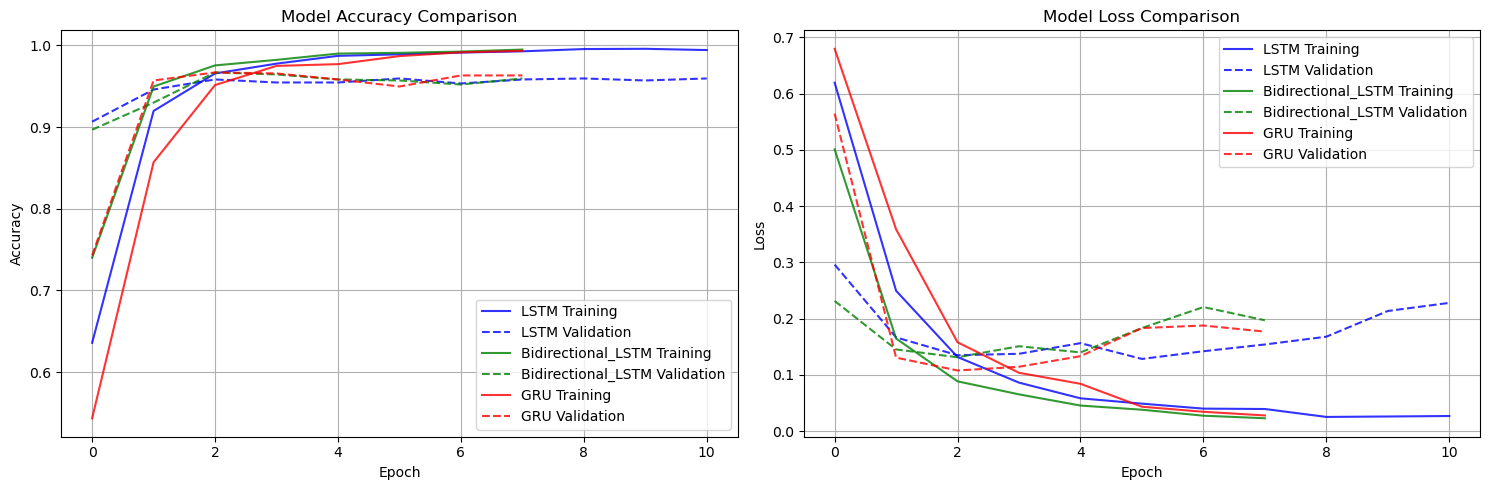


QUANTUM COMPUTING PATENT CLASSIFICATION

FINAL SUMMARY:
--------------------
Dataset: 5079 patents
Best Model: Bidirectional_LSTM
Test Accuracy: 0.9675
Vocabulary Size: 2556
Max Sequence Length of Patent Title: 18


In [11]:
# ====================================================================
# 8. RESULTS AND ANALYSIS
# ====================================================================

print("\n\nRESULTS")
print("-" * 50)

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['val_accuracy'])
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Best validation accuracy: {results[best_model_name]['val_accuracy']:.6f}")

# Test set evaluation
print(f"\nTEST SET EVALUATION:")
print("-" * 30)

y_test_pred = best_model.predict(X_test_pad)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred_binary, 
                          target_names=['Non-Qubit Related', 'Qubit-Related']))

# Test accuracy
test_accuracy = (y_test_pred_binary.flatten() == y_test).mean()
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

# Visualize training history
if len(results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    colors = ['blue', 'green', 'red']
    for i, (name, result) in enumerate(results.items()):
        history = result['history']
        color = colors[i % len(colors)]
        
        # Plot accuracy
        axes[0].plot(history.history['accuracy'], label=f'{name} Training', 
                     color=color, linestyle='-', alpha=0.8)
        axes[0].plot(history.history['val_accuracy'], label=f'{name} Validation', 
                     color=color, linestyle='--', alpha=0.8)
        
        # Plot loss
        axes[1].plot(history.history['loss'], label=f'{name} Training', 
                     color=color, linestyle='-', alpha=0.8)
        axes[1].plot(history.history['val_loss'], label=f'{name} Validation', 
                     color=color, linestyle='--', alpha=0.8)
    
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].set_title('Model Loss Comparison')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("QUANTUM COMPUTING PATENT CLASSIFICATION")
print("="*80)

print(f"\nFINAL SUMMARY:")
print("-" * 20)
print(f"Dataset: {df.shape[0]} patents")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Vocabulary Size: {len(tokenizer.word_index) + 1}")
print(f"Max Sequence Length of Patent Title: {MAX_LEN}")


# Conclusion
When I originally created this program, I had accuracy numbers as high as 97%.  I realized there must be an issue in my code and/or data set where information was leaking between training and test.  I considered where I might have data leakage issues between test and training and realized that the DocDB Family IDs were the likely culprit for why my acccuracy numbers were so high.  While patent documents that share a DocDB Family ID may not be identical, they should all have the same boolean value in the target column (i.e. all family members are Qubit related, or none are related to Qubits).  If some family members are in both train and test that could be causing my data leakage issue.  I removed the additional DocDB Family Id documents (beyond the first unique member of each family) and my data set dropped in size signficantly: 5083 to 1429.  This had the side benefit of significantly improving processing time.  More importantly, however, it also gave me more reasonable acccuracy, precision, recall, and F1 numbers, with accuracy numbers in the 80's instead of 96-97%.    

Why did the DocDB Family ID cause subtle data leakage:  Patent families (DocDB Family ID) are patents that are either identical or closely related and thereby correlate with classification.  If one family member has a boolean value in train and the algorithm is predicting a target value for another family member in test, the machine learning algorithm may merely have learned that patents that belong to the same family have the same boolean value, which is something I already know and don't need the ML algorithm to discover.  So I made the decision to create a data_subset version of this code that only keeps the first member of every unique family and remove second and subsequent members of every unique family in the version of my code that removes the addiitonal patent family members.  

Still, having said all that, there may be some comparative explanatory value to including the full patent families in the analysis.  For that reason, I included this version of my code labeled as the full dataset version of my code which includes the full dataset including all patent family members. 

Here is an example of learning that can occur from keeping the full patent families in the dataset.  For example, one of the patent families in the data set consists of 17 patents, all of which are negative.  Ten of the patents have the identical title "Detection of Electromagnetic Fields".  An 11th patetn has the title "Detection of Electromagnetic Fields as a determinant of an event."  The machine learning algorithm could learn to put more weight on "Detection of Electromagnetic Fields" and less weight on "as a determinant of an event."  Similarly, the 12th and 13th patents have the title "According to signals of electromagnetic fields."  The Machine Learning algorithm could learn to put more weight on "electromagnetic fields" and less weight on the other terms in the patent titles.  This is a demonstration how having the full patent families in the data set can help the machine learning algorithm in creating better weights in the neural network model.       

Future work could include further alternative solutions.  One alternative solution which would not require removing additional patent family members would be control the demarcation between test and train such that all members of a unique family are either in test or train, but not both, thereby preventing data leakage.  Another alternative solution that does not require removing additional patent family members would be to write the algorithms in such a way that once any member of a family receives a classification, all subsequent members of the family automatically receive the same classification.  Under either of those scenarios, the predictions can then focus on the text of the patent titles without worrying about data leakage between training and test. 

All three of the models, LSTM, Bidirectional LSTM, and GRU perform pretty well on this machine learning task.  Patent attorneys are trained to write titles following certain rules, making this a much easier task than analyzing tweets, for example.  Also the title length maximum is a relatively short number of words, in the range of 18-20 words.  Bidirectional LSTM and GRU may perform better on longer titles.  

I believe that these test accuracy numbers are reasonable for this machine learning task.  Patent titles are distinctive between qubit hardware and non-qubit hardware topics. The binary classifification problem could be easy because Qubit-related patents likely contain very specific hardware terms ("superconducting", "quantum dot", "ion trap").  Non-qubit patents focus on algorithms, applications, or other topics with distinctly different vocabulary. Furthermore, patent titles are professional writing that is less noisy than typical text classification tasks.

References
Dataset located at: 
https://github.com/swh/classification-gold-standard

See this World Patent Information article by Steve Harris, Anthony Trippe, David Challis, and Nigel Swycher for the background behind the creation of the dataset.
https://www.sciencedirect.com/science/article/pii/S0172219019300791

https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-lstm-rnn-in-tensorflow/

https://www.analyticsvidhya.com/blog/2022/01/the-complete-lstm-tutorial-with-implementation/

https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/

https://www.geeksforgeeks.org/machine-learning/gated-recurrent-unit-networks/
